<a href="https://colab.research.google.com/github/mohsen990/Camera-Calibration-and-3D-Reconstruction-from-Two-Views-/blob/main/Camera_Calibration_and_3D_Reconstruction_from_Two_Views.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Computer Vision - Homework 1 & 2**

**Mohsen Saadatpour Moghaddam**

In [ ]:
import os

# Create folders for calibration images and scene images
os.makedirs("calib_images", exist_ok=True)
os.makedirs("scene_images", exist_ok=True)

print("Folders created: calib_images/, scene_images/")

Folders created: calib_images/, scene_images/


# **Part 1: Camera Calibration**

Checkerboard configuration:
  Pattern size: (8, 7) internal corners
  Square size: 30.0 mm

Found 13 calibration images:
   calib_images/10.jpg
   calib_images/13.jpg
   calib_images/3.jpg
   calib_images/1.jpg
   calib_images/9.jpg
   calib_images/6.jpg
   calib_images/12.jpg
   calib_images/8.jpg
   calib_images/5.jpg
   calib_images/7.jpg
   calib_images/11.jpg
   calib_images/2.jpg
   calib_images/4.jpg


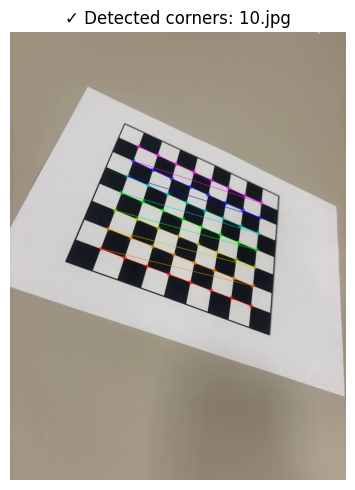

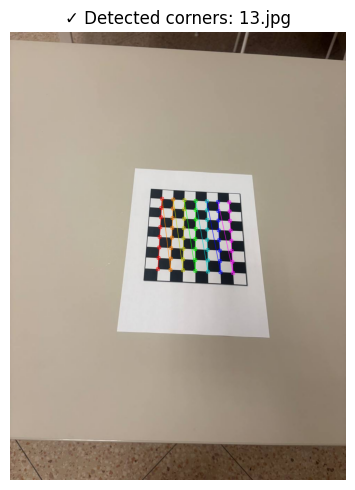

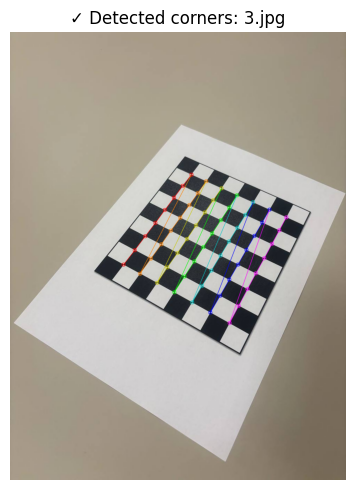

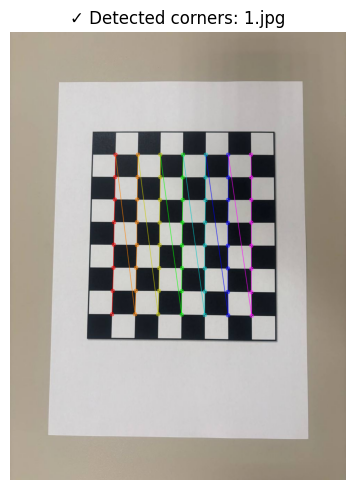

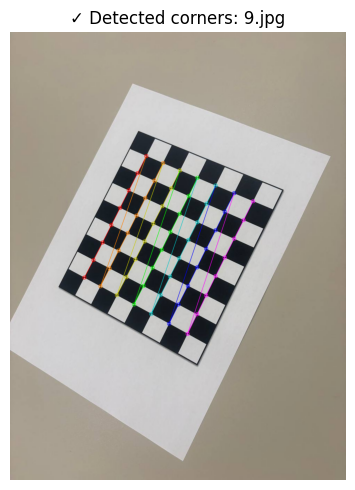

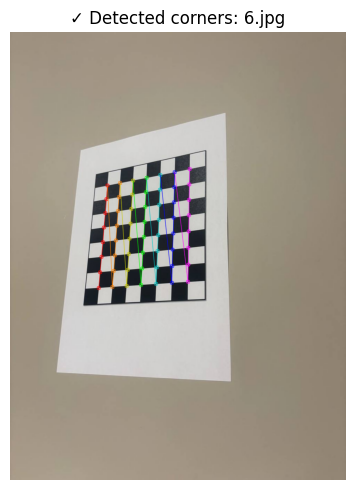

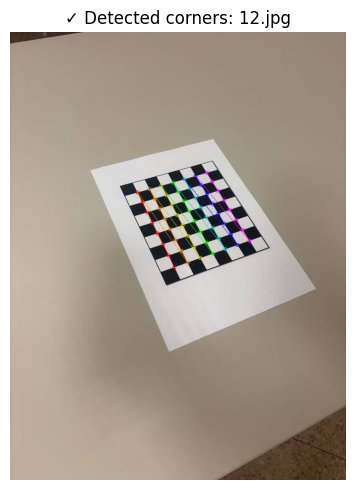

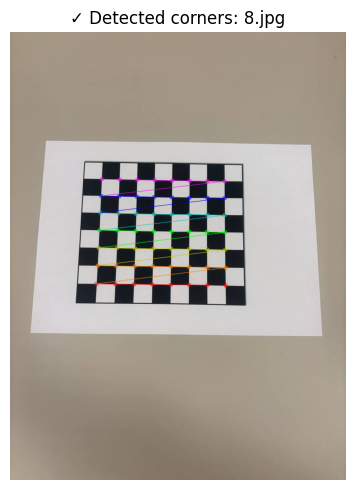

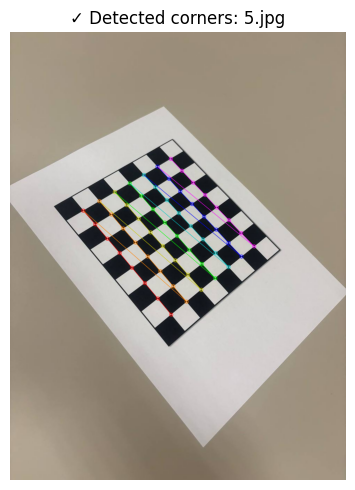

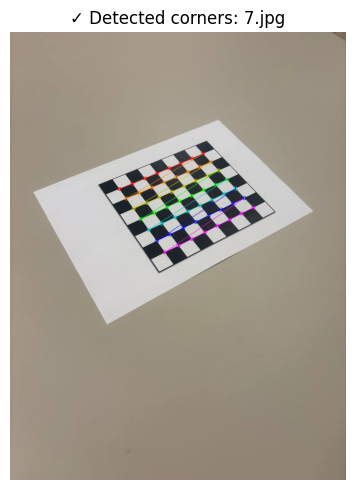

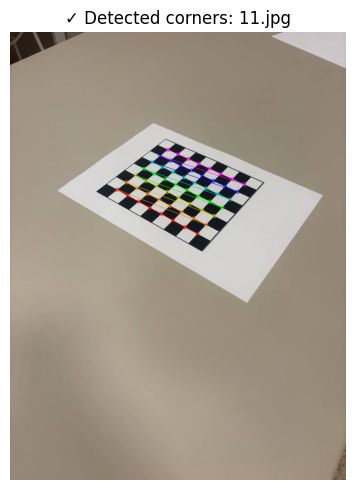

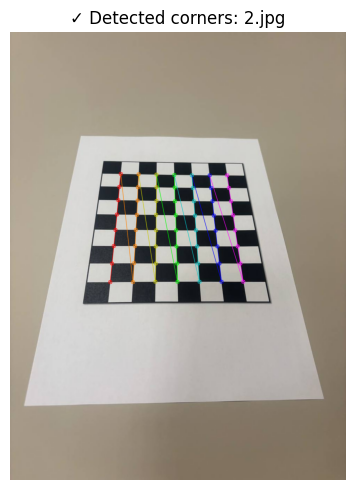

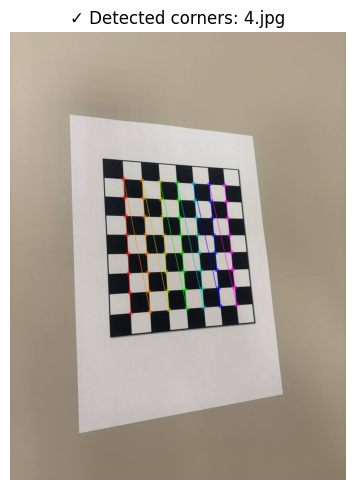


Corner detection summary:
  Successful: 13/13

Performing camera calibration...

CALIBRATION RESULTS

Calibration RMS error: 0.164024

Intrinsic matrix K:
[[985.02789886   0.         479.05468763]
 [  0.         987.89929129 640.34333643]
 [  0.           0.           1.        ]]

Focal lengths: fx=985.03, fy=987.90 pixels
Principal point: cx=479.05, cy=640.34 pixels

Distortion coefficients (k1, k2, p1, p2, k3):
[ 3.01371126e-01 -1.86920531e+00 -5.24762654e-04 -1.04075850e-03
  2.98775785e+00]

Number of calibration views: 13

Example extrinsics for first image:
Rotation matrix R0:
[[-0.90664379  0.19779826 -0.37265653]
 [-0.35443542 -0.83621876  0.41846592]
 [-0.22885055  0.5114822   0.82825925]]

Translation vector t0 (mm):
[ 97.85940378  65.6777915  466.06889263]

REPROJECTION ERROR ANALYSIS
Image 1: RMS error = 0.1594 pixels
Image 2: RMS error = 0.0916 pixels
Image 3: RMS error = 0.1407 pixels
Image 4: RMS error = 0.1692 pixels
Image 5: RMS error = 0.1822 pixels
Image 6: RMS err

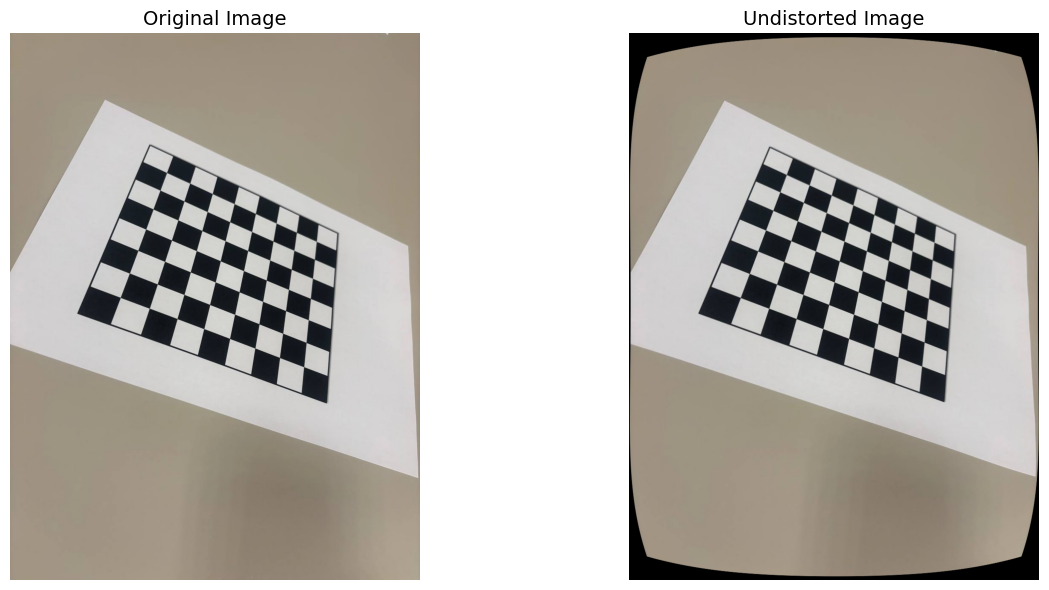

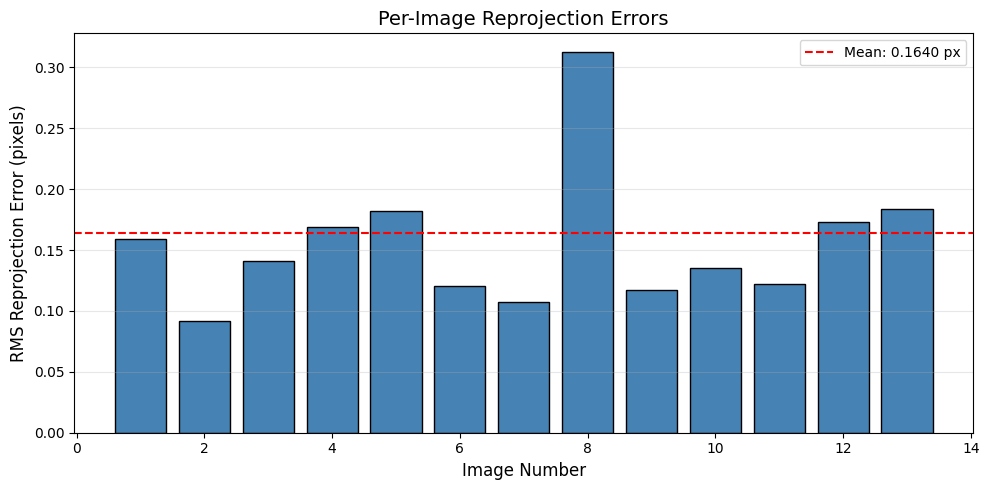


Calibration data saved to 'calibration_data.npz'

Saved parameters:
  - Intrinsic matrix K
  - Distortion coefficients
  - Rotation vectors (rvecs)
  - Translation vectors (tvecs)
  - Image size
  - Mean RMS error
  - Pattern configuration

Ready for Part 2: 3D Reconstruction!


In [ ]:

import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt

# ============================================
# Part 1 – Camera Calibration
# ============================================

# Checkerboard configuration
# Physical pattern: 9 cols × 8 rows of SQUARES
# Internal corners: 8 cols × 7 rows
inner_cols = 8    # 9 squares horizontally → 8 internal corners
inner_rows = 7    # 8 squares vertically → 7 internal corners
pattern_size = (inner_cols, inner_rows)  # OpenCV uses (cols, rows)

square_size_mm = 30.0  # measured square size in millimeters

print(f"Checkerboard configuration:")
print(f"  Pattern size: {pattern_size} internal corners")
print(f"  Square size: {square_size_mm} mm")

criteria = (
    cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
    30,
    0.001
)

# Prepare 3D object points in pattern reference frame (z = 0)
objp = np.zeros((inner_rows * inner_cols, 3), np.float32)
objp[:, :2] = np.mgrid[0:inner_cols, 0:inner_rows].T.reshape(-1, 2)
objp *= square_size_mm  # coordinates in millimeters

objpoints = []  # 3D points in world space
imgpoints = []  # 2D points in image plane

# Load calibration images
image_files = glob.glob("calib_images/*.jpg")

print(f"\nFound {len(image_files)} calibration images:")
for f in image_files:
    print("  ", f)

if len(image_files) == 0:
    raise RuntimeError("No calibration images found in calib_images/")

# Detect corners in each image
successful_detections = 0
for fname in image_files:
    img = cv2.imread(fname)
    if img is None:
        print(f"⚠ Could not read: {fname}")
        continue

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Try to find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)

    if ret:
        # Refine corner positions to sub-pixel accuracy
        corners_subpix = cv2.cornerSubPix(
            gray,
            corners,
            winSize=(11, 11),
            zeroZone=(-1, -1),
            criteria=criteria
        )

        objpoints.append(objp)
        imgpoints.append(corners_subpix)
        successful_detections += 1

        # Visualize detected corners
        vis = img.copy()
        cv2.drawChessboardCorners(vis, pattern_size, corners_subpix, ret)
        vis_rgb = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(6, 5))
        plt.title(f"✓ Detected corners: {fname.split('/')[-1]}")
        plt.imshow(vis_rgb)
        plt.axis("off")
        plt.tight_layout()
        plt.show()

    else:
        print(f"✗ Chessboard NOT found in: {fname}")

print(f"\n{'='*60}")
print(f"Corner detection summary:")
print(f"  Successful: {successful_detections}/{len(image_files)}")
print(f"{'='*60}")

if len(objpoints) < 3:
    raise RuntimeError(f"Only {len(objpoints)} valid detections. Need at least 3!")

# ============================================
# Camera Calibration
# ============================================

print("\nPerforming camera calibration...")

img0 = cv2.imread(image_files[0])
gray0 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
image_size = gray0.shape[::-1]  # (width, height)

ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints,
    imgpoints,
    image_size,
    None,
    None
)

print(f"\n{'='*60}")
print("CALIBRATION RESULTS")
print(f"{'='*60}")
print(f"\nCalibration RMS error: {ret:.6f}")
print(f"\nIntrinsic matrix K:")
print(K)
print(f"\nFocal lengths: fx={K[0,0]:.2f}, fy={K[1,1]:.2f} pixels")
print(f"Principal point: cx={K[0,2]:.2f}, cy={K[1,2]:.2f} pixels")
print(f"\nDistortion coefficients (k1, k2, p1, p2, k3):")
print(dist.ravel())
print(f"\nNumber of calibration views: {len(rvecs)}")

# Show example extrinsics for first image
R0, _ = cv2.Rodrigues(rvecs[0])
t0 = tvecs[0]
print(f"\nExample extrinsics for first image:")
print("Rotation matrix R0:")
print(R0)
print("\nTranslation vector t0 (mm):")
print(t0.ravel())

# ============================================
# Reprojection Error Analysis
# ============================================

print(f"\n{'='*60}")
print("REPROJECTION ERROR ANALYSIS")
print(f"{'='*60}")

total_error_sq = 0
total_points = 0
per_image_errors = []

for i in range(len(objpoints)):
    imgpoints_proj, _ = cv2.projectPoints(
        objpoints[i],
        rvecs[i],
        tvecs[i],
        K,
        dist
    )

    # Compute squared error
    error_sq = cv2.norm(imgpoints[i], imgpoints_proj, cv2.NORM_L2) ** 2
    num_points = len(imgpoints_proj)

    total_error_sq += error_sq
    total_points += num_points

    # Per-image RMS error
    per_image_rms = np.sqrt(error_sq / num_points)
    per_image_errors.append(per_image_rms)
    print(f"Image {i+1}: RMS error = {per_image_rms:.4f} pixels")

# Overall mean RMS error
mean_rms_error = np.sqrt(total_error_sq / total_points)

print(f"\nOverall mean RMS reprojection error: {mean_rms_error:.4f} pixels")
print(f"Min error: {min(per_image_errors):.4f} pixels")
print(f"Max error: {max(per_image_errors):.4f} pixels")
print(f"Std dev: {np.std(per_image_errors):.4f} pixels")

# Quality assessment
if mean_rms_error < 0.5:
    quality = "EXCELLENT ✓✓✓"
elif mean_rms_error < 1.0:
    quality = "GOOD ✓✓"
elif mean_rms_error < 2.0:
    quality = "ACCEPTABLE ✓"
else:
    quality = "POOR - consider recalibrating ✗"

print(f"\nCalibration quality: {quality}")

# ============================================
# Visualization: Undistortion Example
# ============================================

print("\nGenerating undistortion comparison...")

undistorted = cv2.undistort(img0, K, dist, None)
orig_rgb = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
undist_rgb = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image", fontsize=14)
plt.imshow(orig_rgb)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Undistorted Image", fontsize=14)
plt.imshow(undist_rgb)
plt.axis("off")

plt.tight_layout()
plt.show()

# Plot reprojection errors
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(per_image_errors) + 1), per_image_errors,
        color='steelblue', edgecolor='black')
plt.axhline(y=mean_rms_error, color='red', linestyle='--',
            label=f'Mean: {mean_rms_error:.4f} px')
plt.xlabel('Image Number', fontsize=12)
plt.ylabel('RMS Reprojection Error (pixels)', fontsize=12)
plt.title('Per-Image Reprojection Errors', fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================
# Save Calibration Data for Part 2
# ============================================

output_file = "calibration_data.npz"

np.savez(output_file,
         K=K,
         dist=dist,
         rvecs=rvecs,
         tvecs=tvecs,
         image_size=image_size,
         mean_error=mean_rms_error,
         square_size_mm=square_size_mm,
         pattern_size=pattern_size)

print(f"\n{'='*60}")
print(f"Calibration data saved to '{output_file}'")
print(f"{'='*60}")
print("\nSaved parameters:")
print(f"  - Intrinsic matrix K")
print(f"  - Distortion coefficients")
print(f"  - Rotation vectors (rvecs)")
print(f"  - Translation vectors (tvecs)")
print(f"  - Image size")
print(f"  - Mean RMS error")
print(f"  - Pattern configuration")
print("\nReady for Part 2: 3D Reconstruction!")

# **Part 2: 3D Reconstruction from Two Views**

PART 2: 3D RECONSTRUCTION FROM TWO VIEWS

Loading calibration data...
Intrinsic matrix K:
[[985.02789886   0.         479.05468763]
 [  0.         987.89929129 640.34333643]
 [  0.           0.           1.        ]]

Distortion coefficients:
[[ 3.01371126e-01 -1.86920531e+00 -5.24762654e-04 -1.04075850e-03
   2.98775785e+00]]

Loading scene images...
  Image 1: scene_images/qq.jpg
  Image 2: scene_images/ww.jpg
Image 1 shape: (1280, 960, 3)
Image 2 shape: (1280, 960, 3)

2.1 FEATURE EXTRACTION AND MATCHING

Using SIFT features...
Keypoints detected:
  Image 1: 784
  Image 2: 696

Initial matches: 784
Good matches after ratio test: 243

Visualizing feature matches...


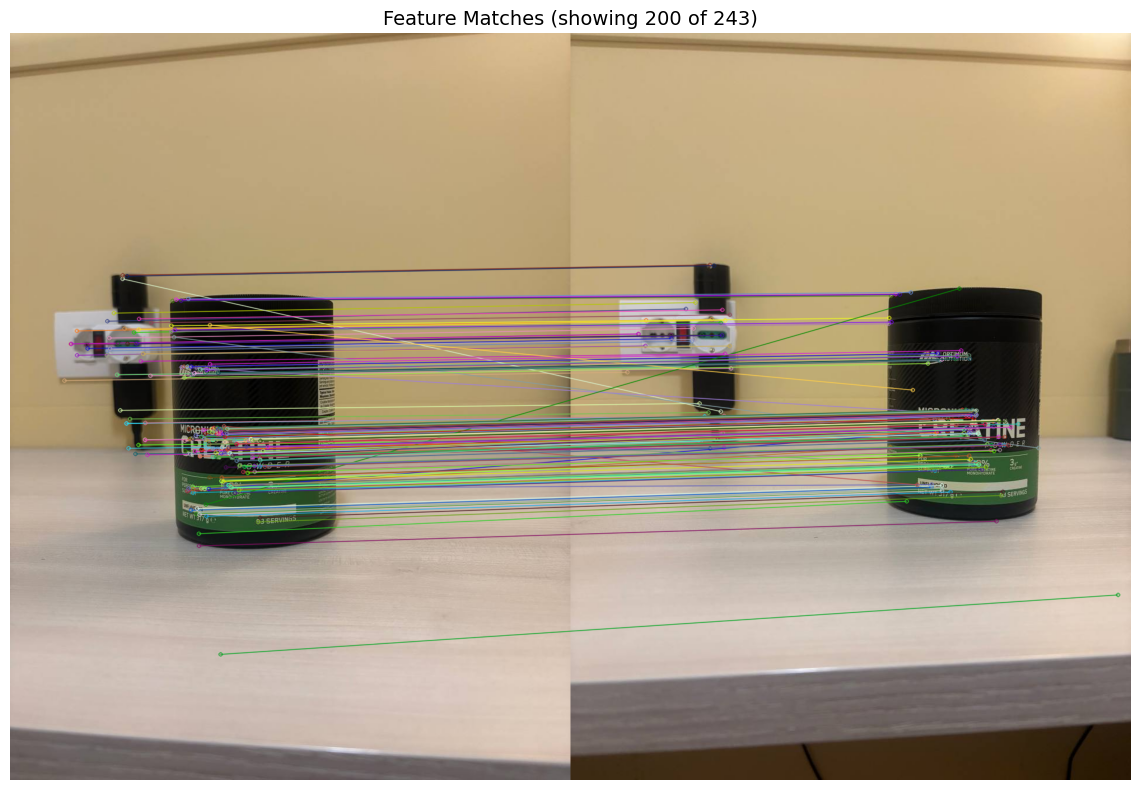


2.2 EPIPOLAR GEOMETRY ESTIMATION

Estimating essential matrix E with RANSAC...

Essential matrix E:
[[-0.01011473 -0.18937195 -0.0381248 ]
 [-0.00704007  0.00339432 -0.70600181]
 [ 0.03486039  0.68030265 -0.00747468]]

Inliers from E estimation: 194/243 (79.8%)

Recovering camera pose (R, t)...
Points in front of both cameras: 194/194

Rotation matrix R:
[[ 0.96057121  0.00466057 -0.27799501]
 [-0.00345045  0.99998232  0.00484213]
 [ 0.27801266 -0.003692    0.96057031]]

Translation vector t (unit vector):
[ 0.96185493 -0.05477873  0.26801936]

Rotation angle between views: 16.14°

Visualizing epipolar geometry...


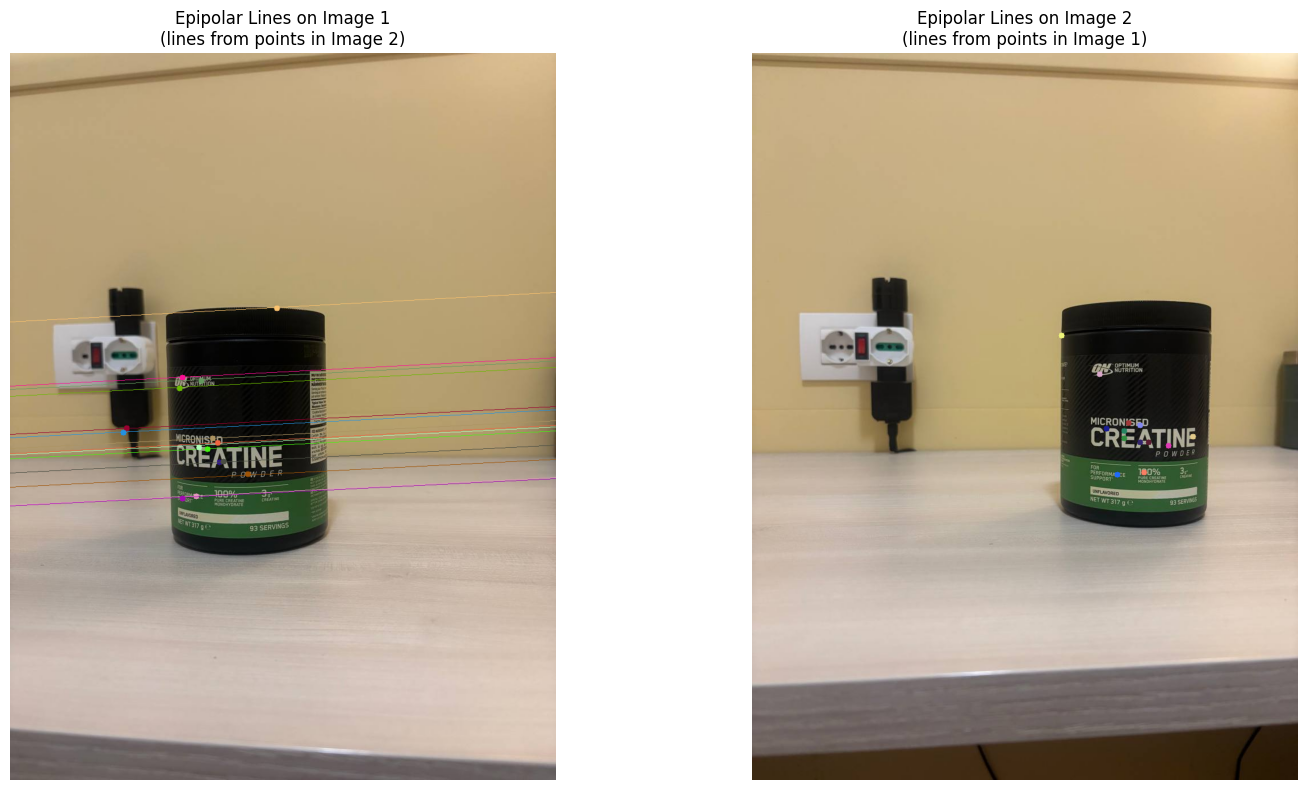


2.3 TRIANGULATION AND 3D RECONSTRUCTION
Projection matrix P1:
[[985.02789886   0.         479.05468763   0.        ]
 [  0.         987.89929129 640.34333643   0.        ]
 [  0.           0.           1.           0.        ]]

Projection matrix P2:
[[ 1.07937271e+03  2.82212331e+00  1.86332875e+02  1.07584988e+03]
 [ 1.74614858e+02  9.85517682e+02  6.19878333e+02  1.17508545e+02]
 [ 2.78012660e-01 -3.69199918e-03  9.60570315e-01  2.68019360e-01]]

Triangulating 194 point correspondences...
Reconstructed 194 3D points

Depth statistics (Camera 1):
  Min: 1.54, Max: 3.29
  Mean: 1.89, Median: 1.57

After depth filtering: 194/194

Reprojection errors:
  Camera 1 - Mean: 1.82, Max: 6.12
  Camera 2 - Mean: 2.60, Max: 5.86

After reprojection filtering: 194/194

3D Point Cloud Statistics:
  X range: [-1.27, 0.01]
  Y range: [-0.67, 0.31]
  Z range: [1.54, 3.29]

Visualizing 3D reconstruction...


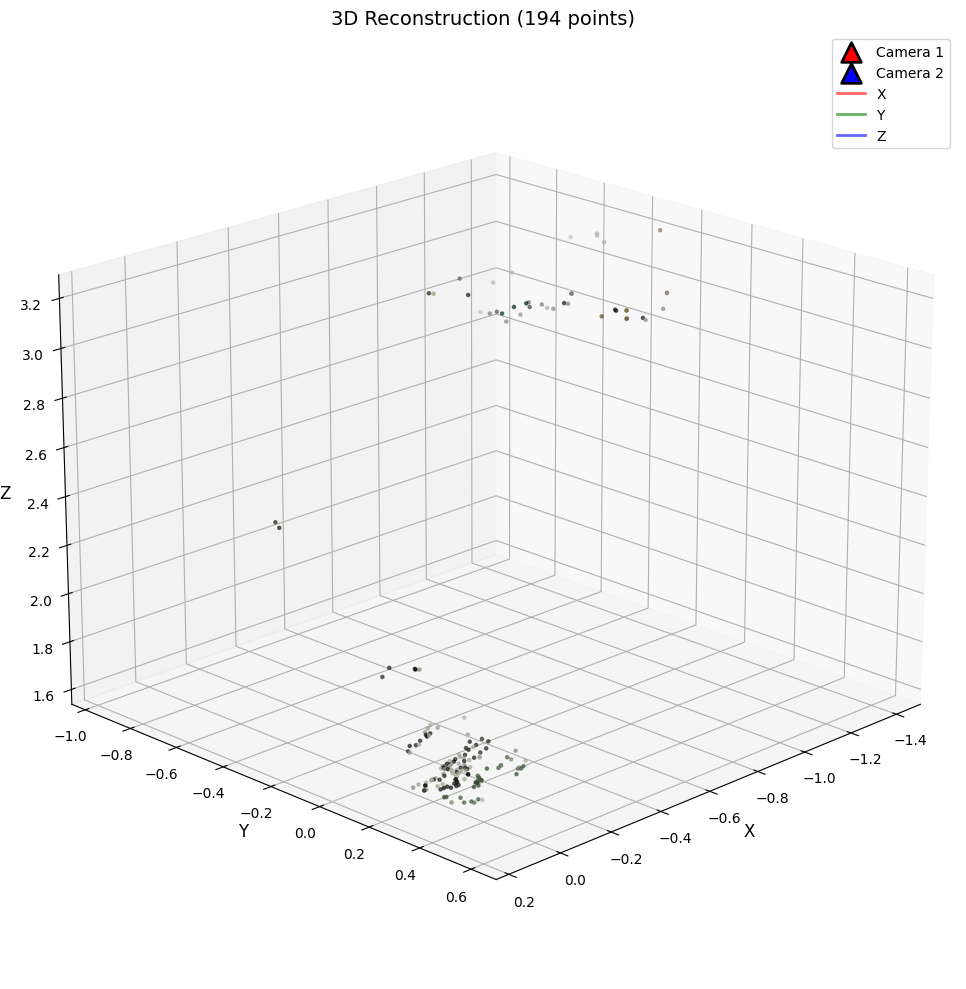

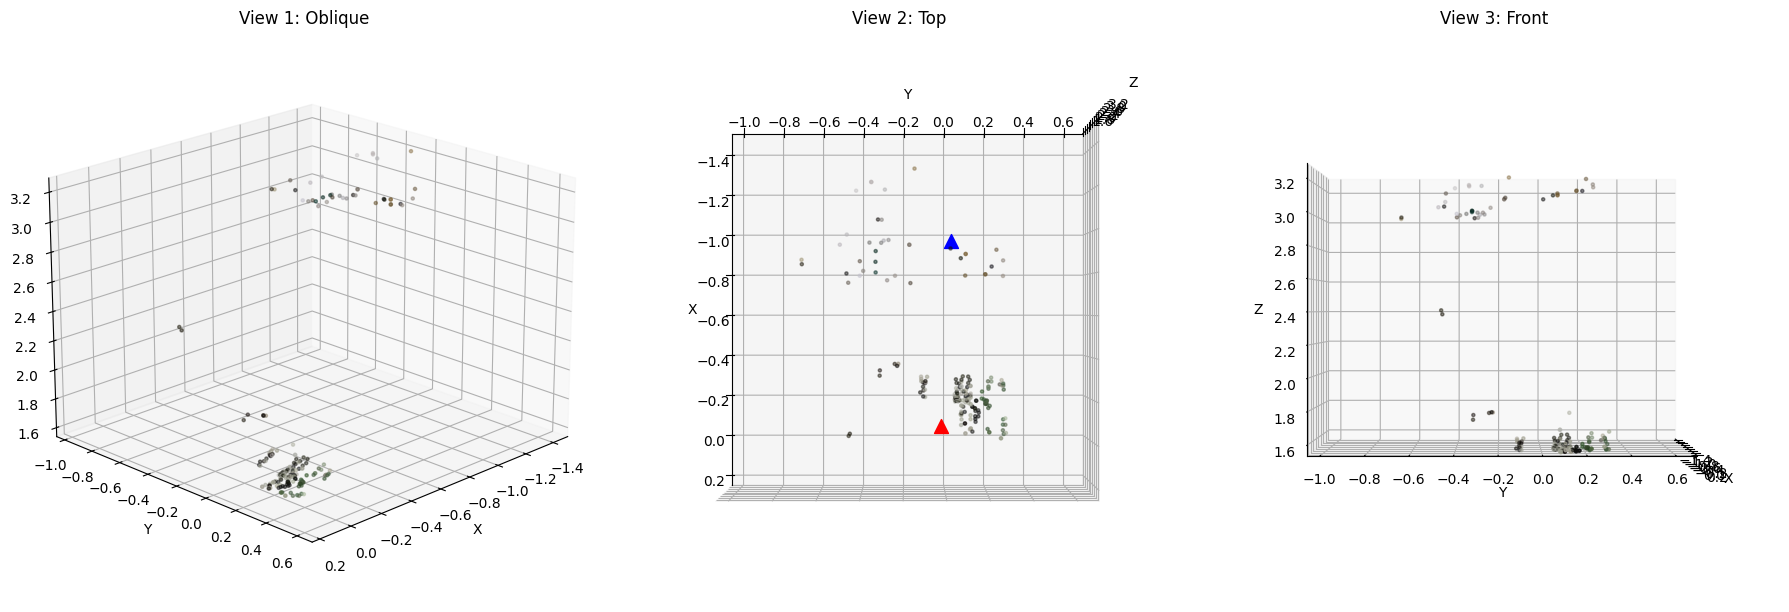


Saving reconstruction results...
Saved to 'reconstruction_results.npz'

3D RECONSTRUCTION COMPLETE!

Summary:
  - Initial keypoints: 784, 696
  - Feature matches: 243
  - Inliers after RANSAC: 194 (79.8%)
  - 3D points reconstructed: 194
  - Rotation between views: 16.14°
  - Baseline (translation): 1.0000 (normalized)



In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ============================================
# Part 2 – 3D Reconstruction from Two Views
# ============================================

print("="*60)
print("PART 2: 3D RECONSTRUCTION FROM TWO VIEWS")
print("="*60)

# ============================================
# Load Calibration Data
# ============================================

print("\nLoading calibration data...")
calib_data = np.load("calibration_data.npz")
K = calib_data['K']
dist = calib_data['dist']

print("Intrinsic matrix K:")
print(K)
print("\nDistortion coefficients:")
print(dist)

# ============================================
# Load Images
# ============================================

# MODIFY THESE PATHS TO YOUR IMAGES
image1_path = "scene_images/qq.jpg"
image2_path = "scene_images/ww.jpg"

print(f"\nLoading scene images...")
print(f"  Image 1: {image1_path}")
print(f"  Image 2: {image2_path}")

img1 = cv2.imread(image1_path)
img2 = cv2.imread(image2_path)

if img1 is None or img2 is None:
    raise FileNotFoundError("Could not load scene images. Check paths!")

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

print(f"Image 1 shape: {img1.shape}")
print(f"Image 2 shape: {img2.shape}")

# ============================================
# 2.1 Feature Extraction and Matching
# ============================================

print("\n" + "="*60)
print("2.1 FEATURE EXTRACTION AND MATCHING")
print("="*60)

# Choose feature detector: 'SIFT' or 'ORB'
FEATURE_TYPE = 'SIFT'  # SIFT is more robust

print(f"\nUsing {FEATURE_TYPE} features...")

if FEATURE_TYPE == 'SIFT':
    # Increase number of features for better coverage
    detector = cv2.SIFT_create(nfeatures=10000, contrastThreshold=0.03, edgeThreshold=15)
    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
elif FEATURE_TYPE == 'ORB':
    detector = cv2.ORB_create(nfeatures=10000, scaleFactor=1.2, nlevels=8)
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
else:
    raise ValueError("FEATURE_TYPE must be 'SIFT' or 'ORB'")

# Detect keypoints and compute descriptors
kp1, des1 = detector.detectAndCompute(gray1, None)
kp2, des2 = detector.detectAndCompute(gray2, None)

print(f"Keypoints detected:")
print(f"  Image 1: {len(kp1)}")
print(f"  Image 2: {len(kp2)}")

if len(kp1) < 50 or len(kp2) < 50:
    print("\n⚠️  WARNING: Very few keypoints detected!")
    print("Your images may lack texture. Consider:")
    print("  - Using an object with more visual detail")
    print("  - Better lighting")
    print("  - Different camera angle")

# Match descriptors using k-NN (k=2 for ratio test)
matches = matcher.knnMatch(des1, des2, k=2)
print(f"\nInitial matches: {len(matches)}")

# Apply Lowe's ratio test with more lenient threshold
RATIO_THRESHOLD = 0.80  # Increased from 0.75
good_matches = []
for match_pair in matches:
    if len(match_pair) == 2:
        m, n = match_pair
        if m.distance < RATIO_THRESHOLD * n.distance:
            good_matches.append(m)

print(f"Good matches after ratio test: {len(good_matches)}")

if len(good_matches) < 20:
    print("\n⚠️  WARNING: Very few matches found!")
    print(f"Only {len(good_matches)} matches - reconstruction may be poor.")
    print("Recommendations:")
    print("  1. Ensure object has rich texture (text, patterns)")
    print("  2. Check that images have good overlap")
    print("  3. Verify baseline (camera movement) is not too large")
    print("  4. Try adjusting RATIO_THRESHOLD (0.75-0.85)")

# Visualize matches
print("\nVisualizing feature matches...")
num_display = min(200, len(good_matches))
img_matches = cv2.drawMatches(
    img1, kp1, img2, kp2,
    good_matches[:num_display],
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(16, 8))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title(f"Feature Matches (showing {num_display} of {len(good_matches)})", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

# ============================================
# 2.2 Epipolar Geometry Estimation
# ============================================

print("\n" + "="*60)
print("2.2 EPIPOLAR GEOMETRY ESTIMATION")
print("="*60)

# Extract matched point coordinates
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

print(f"\nEstimating essential matrix E with RANSAC...")

# Directly estimate essential matrix (better for calibrated cameras)
E, mask_E = cv2.findEssentialMat(
    pts1, pts2, K,
    method=cv2.RANSAC,
    prob=0.999,
    threshold=3.0  # More lenient threshold (increased from 1.0)
)

inliers_E = np.sum(mask_E)
inlier_ratio = inliers_E / len(good_matches) * 100

print(f"\nEssential matrix E:")
print(E)
print(f"\nInliers from E estimation: {inliers_E}/{len(good_matches)} ({inlier_ratio:.1f}%)")

if inlier_ratio < 30:
    print(f"\n⚠️  WARNING: Low inlier ratio ({inlier_ratio:.1f}%)")
    print("This suggests:")
    print("  - Images may not have good overlap")
    print("  - Scene may not be rigid")
    print("  - Baseline may be too large")

mask_inliers = mask_E.ravel().astype(bool)

# Recover camera pose from essential matrix
print(f"\nRecovering camera pose (R, t)...")
_, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, K, mask=mask_E)

points_tested = np.sum(mask_pose > 0)
print(f"Points in front of both cameras: {points_tested}/{inliers_E}")

print(f"\nRotation matrix R:")
print(R)
print(f"\nTranslation vector t (unit vector):")
print(t.ravel())

# Compute rotation angle
rotation_angle = np.arccos(np.clip((np.trace(R) - 1) / 2, -1, 1)) * 180 / np.pi
print(f"\nRotation angle between views: {rotation_angle:.2f}°")

# Compute fundamental matrix for visualization
F = np.linalg.inv(K).T @ E @ np.linalg.inv(K)

# Visualize epipolar lines
print("\nVisualizing epipolar geometry...")

def draw_epipolar_lines(img1, img2, lines, pts1, pts2, num_lines=15):
    """Draw epipolar lines on images"""
    h, w = img1.shape[:2]
    img1_lines = img1.copy()
    img2_lines = img2.copy()

    # Select random subset for visualization
    num_lines = min(num_lines, len(pts1))
    indices = np.random.choice(len(pts1), num_lines, replace=False)

    for i in indices:
        color = tuple(np.random.randint(0, 255, 3).tolist())

        # Draw epiline on img1
        x0, y0 = map(int, [0, -lines[i][2]/lines[i][1]])
        x1, y1 = map(int, [w, -(lines[i][2] + lines[i][0]*w)/lines[i][1]])
        cv2.line(img1_lines, (x0, y0), (x1, y1), color, 1)
        cv2.circle(img1_lines, tuple(pts1[i].astype(int)), 5, color, -1)

        # Draw corresponding point on img2
        cv2.circle(img2_lines, tuple(pts2[i].astype(int)), 5, color, -1)

    return img1_lines, img2_lines

# Get inlier points
pts1_inliers = pts1[mask_inliers]
pts2_inliers = pts2[mask_inliers]

# Compute epilines
lines1 = cv2.computeCorrespondEpilines(pts2_inliers.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)

lines2 = cv2.computeCorrespondEpilines(pts1_inliers.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)

img1_epi, img2_temp = draw_epipolar_lines(img1, img2, lines1, pts1_inliers, pts2_inliers)
img1_temp, img2_epi = draw_epipolar_lines(img1, img2, lines2, pts1_inliers, pts2_inliers)

# Display epipolar lines
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(cv2.cvtColor(img1_epi, cv2.COLOR_BGR2RGB))
axes[0].set_title('Epipolar Lines on Image 1\n(lines from points in Image 2)', fontsize=12)
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(img2_epi, cv2.COLOR_BGR2RGB))
axes[1].set_title('Epipolar Lines on Image 2\n(lines from points in Image 1)', fontsize=12)
axes[1].axis('off')

plt.tight_layout()
plt.show()

# ============================================
# 2.3 Triangulation and 3D Reconstruction
# ============================================

print("\n" + "="*60)
print("2.3 TRIANGULATION AND 3D RECONSTRUCTION")
print("="*60)

# Construct projection matrices
P1 = K @ np.hstack([np.eye(3), np.zeros((3, 1))])  # [K | 0]
P2 = K @ np.hstack([R, t])  # [K*R | K*t]

print("Projection matrix P1:")
print(P1)
print("\nProjection matrix P2:")
print(P2)

# Normalize points for triangulation
pts1_norm = cv2.undistortPoints(
    pts1_inliers.reshape(-1, 1, 2), K, dist
).reshape(-1, 2)

pts2_norm = cv2.undistortPoints(
    pts2_inliers.reshape(-1, 1, 2), K, dist
).reshape(-1, 2)

# Triangulate points
print(f"\nTriangulating {len(pts1_inliers)} point correspondences...")

# Use normalized coordinates for better numerical stability
P1_norm = np.hstack([np.eye(3), np.zeros((3, 1))])
P2_norm = np.hstack([R, t])

points_4d_hom = cv2.triangulatePoints(P1_norm, P2_norm, pts1_norm.T, pts2_norm.T)
points_3d = points_4d_hom[:3, :] / points_4d_hom[3, :]
points_3d = points_3d.T

print(f"Reconstructed {len(points_3d)} 3D points")

# Analyze point depths
depths_cam1 = points_3d[:, 2]
depths_cam2 = (R @ points_3d.T + t).T[:, 2]

print(f"\nDepth statistics (Camera 1):")
print(f"  Min: {depths_cam1.min():.2f}, Max: {depths_cam1.max():.2f}")
print(f"  Mean: {depths_cam1.mean():.2f}, Median: {np.median(depths_cam1):.2f}")

# Filter based on positive depth (cheirality constraint)
mask_positive_depth = (depths_cam1 > 0) & (depths_cam2 > 0)
points_before_depth = len(points_3d)
points_3d_valid = points_3d[mask_positive_depth]
pts1_valid = pts1_inliers[mask_positive_depth]
pts2_valid = pts2_inliers[mask_positive_depth]

print(f"\nAfter depth filtering: {len(points_3d_valid)}/{points_before_depth}")

if len(points_3d_valid) == 0:
    print("\n❌ ERROR: No points have positive depth!")
    print("This means triangulation failed completely.")
    print("\nPossible causes:")
    print("  1. Baseline too small (move camera more)")
    print("  2. Baseline too large (too much movement)")
    print("  3. Poor feature matches")
    print("  4. Scene not rigid")
    raise ValueError("No valid 3D points after depth filtering")

# More lenient reprojection filtering
def compute_reprojection_error_simple(points_3d, pts_2d, K, R_mat, t_vec):
    """Simplified reprojection error computation"""
    # Transform to camera frame
    if not np.allclose(R_mat, np.eye(3)):
        points_cam = (R_mat @ points_3d.T + t_vec).T
    else:
        points_cam = points_3d

    # Project to image
    pts_proj = K @ points_cam.T
    pts_proj = (pts_proj[:2, :] / pts_proj[2, :]).T

    # Compute error
    errors = np.linalg.norm(pts_2d - pts_proj, axis=1)
    return errors

errors1 = compute_reprojection_error_simple(points_3d_valid, pts1_valid, K, np.eye(3), np.zeros((3,1)))
errors2 = compute_reprojection_error_simple(points_3d_valid, pts2_valid, K, R, t)

print(f"\nReprojection errors:")
print(f"  Camera 1 - Mean: {errors1.mean():.2f}, Max: {errors1.max():.2f}")
print(f"  Camera 2 - Mean: {errors2.mean():.2f}, Max: {errors2.max():.2f}")

# More lenient threshold
MAX_REPROJ_ERROR = 10.0  # Increased from 5.0
mask_good_reproj = (errors1 < MAX_REPROJ_ERROR) & (errors2 < MAX_REPROJ_ERROR)

points_3d_filtered = points_3d_valid[mask_good_reproj]
pts1_filtered = pts1_valid[mask_good_reproj]

print(f"\nAfter reprojection filtering: {len(points_3d_filtered)}/{len(points_3d_valid)}")

if len(points_3d_filtered) == 0:
    print("\n⚠️  WARNING: All points removed by reprojection filter!")
    print("Using less strict filtering...")
    MAX_REPROJ_ERROR = 50.0
    mask_good_reproj = (errors1 < MAX_REPROJ_ERROR) & (errors2 < MAX_REPROJ_ERROR)
    points_3d_filtered = points_3d_valid[mask_good_reproj]
    pts1_filtered = pts1_valid[mask_good_reproj]
    print(f"Recovered {len(points_3d_filtered)} points with lenient threshold")

if len(points_3d_filtered) == 0:
    print("\n❌ CRITICAL: No valid points remain!")
    print("Reconstruction failed. Please check your images and try again.")
    raise ValueError("No valid 3D points after all filtering")

# Get colors from image 1
colors = []
for pt in pts1_filtered.astype(int):
    x, y = pt
    if 0 <= y < img1.shape[0] and 0 <= x < img1.shape[1]:
        color = img1[y, x][::-1] / 255.0  # BGR to RGB, normalize
        colors.append(color)
    else:
        colors.append([0.5, 0.5, 0.5])
colors = np.array(colors)

# Statistics
print(f"\n3D Point Cloud Statistics:")
print(f"  X range: [{points_3d_filtered[:, 0].min():.2f}, {points_3d_filtered[:, 0].max():.2f}]")
print(f"  Y range: [{points_3d_filtered[:, 1].min():.2f}, {points_3d_filtered[:, 1].max():.2f}]")
print(f"  Z range: [{points_3d_filtered[:, 2].min():.2f}, {points_3d_filtered[:, 2].max():.2f}]")

# ============================================
# Visualization: 3D Point Cloud
# ============================================

print("\nVisualizing 3D reconstruction...")

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot 3D points
point_size = max(1, min(10, 1000 / len(points_3d_filtered)))
ax.scatter(
    points_3d_filtered[:, 0],
    points_3d_filtered[:, 1],
    points_3d_filtered[:, 2],
    c=colors,
    marker='o',
    s=point_size,
    alpha=0.6
)

# Plot camera positions
ax.scatter([0], [0], [0], c='red', marker='^', s=200, label='Camera 1', edgecolors='black', linewidths=2)

cam2_pos = -R.T @ t
ax.scatter(
    [cam2_pos[0, 0]],
    [cam2_pos[1, 0]],
    [cam2_pos[2, 0]],
    c='blue',
    marker='^',
    s=200,
    label='Camera 2',
    edgecolors='black',
    linewidths=2
)

# Draw camera axes
axis_length = (points_3d_filtered[:, 2].max() - points_3d_filtered[:, 2].min()) * 0.2
# Camera 1 axes
ax.plot([0, axis_length], [0, 0], [0, 0], 'r-', linewidth=2, alpha=0.6, label='X')
ax.plot([0, 0], [0, axis_length], [0, 0], 'g-', linewidth=2, alpha=0.6, label='Y')
ax.plot([0, 0], [0, 0], [0, axis_length], 'b-', linewidth=2, alpha=0.6, label='Z')

ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.set_zlabel('Z', fontsize=12)
ax.set_title(f'3D Reconstruction ({len(points_3d_filtered)} points)', fontsize=14)
ax.legend(fontsize=10)

# Set equal aspect ratio
max_range = np.array([
    points_3d_filtered[:, 0].max() - points_3d_filtered[:, 0].min(),
    points_3d_filtered[:, 1].max() - points_3d_filtered[:, 1].min(),
    points_3d_filtered[:, 2].max() - points_3d_filtered[:, 2].min()
]).max() / 2.0

mid_x = (points_3d_filtered[:, 0].max() + points_3d_filtered[:, 0].min()) * 0.5
mid_y = (points_3d_filtered[:, 1].max() + points_3d_filtered[:, 1].min()) * 0.5
mid_z = (points_3d_filtered[:, 2].max() + points_3d_filtered[:, 2].min()) * 0.5

ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

# Multiple viewing angles
fig = plt.figure(figsize=(18, 6))

for i, (elev, azim, title) in enumerate([
    (20, 45, 'View 1: Oblique'),
    (90, 0, 'View 2: Top'),
    (0, 0, 'View 3: Front')
]):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')

    ax.scatter(
        points_3d_filtered[:, 0],
        points_3d_filtered[:, 1],
        points_3d_filtered[:, 2],
        c=colors,
        marker='o',
        s=point_size,
        alpha=0.5
    )

    ax.scatter([0], [0], [0], c='red', marker='^', s=100)
    ax.scatter([cam2_pos[0,0]], [cam2_pos[1,0]], [cam2_pos[2,0]], c='blue', marker='^', s=100)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    ax.view_init(elev=elev, azim=azim)

plt.tight_layout()
plt.show()

# ============================================
# Save Results
# ============================================

print("\n" + "="*60)
print("Saving reconstruction results...")

np.savez(
    "reconstruction_results.npz",
    points_3d=points_3d_filtered,
    colors=colors,
    R=R,
    t=t,
    E=E,
    P1=P1,
    P2=P2,
    num_inliers=len(points_3d_filtered),
    num_matches=len(good_matches)
)

print("Saved to 'reconstruction_results.npz'")

print("\n" + "="*60)
print("3D RECONSTRUCTION COMPLETE!")
print("="*60)
print(f"\nSummary:")
print(f"  - Initial keypoints: {len(kp1)}, {len(kp2)}")
print(f"  - Feature matches: {len(good_matches)}")
print(f"  - Inliers after RANSAC: {inliers_E} ({inlier_ratio:.1f}%)")
print(f"  - 3D points reconstructed: {len(points_3d_filtered)}")
print(f"  - Rotation between views: {rotation_angle:.2f}°")
print(f"  - Baseline (translation): {np.linalg.norm(t):.4f} (normalized)")
print("\n" + "="*60)